In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import heapq
import warnings
warnings.filterwarnings('ignore')

DATASET_PATH = '/content/drive/MyDrive/bitbrains'

files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.csv')]
print(f"Found {len(files)} CSV files in dataset")

Mounted at /content/drive
Found 1266 CSV files in dataset


In [2]:
all_data = []

for i, filename in enumerate(files):
    if i % 100 == 0:
        print(f"Processing file {i}/{len(files)}")

    filepath = os.path.join(DATASET_PATH, filename)

    try:
        df = pd.read_csv(filepath, delimiter=';')
        if len(df) > 0:
            vm_features = df.mean(numeric_only=True)
            all_data.append(vm_features)
    except:
        continue

dataset = pd.DataFrame(all_data)
print(f"Total VMs loaded: {len(dataset)}")
print(f"Features per VM: {dataset.shape[1]}")

Processing file 0/1266
Processing file 100/1266
Processing file 200/1266
Processing file 300/1266
Processing file 400/1266
Processing file 500/1266
Processing file 600/1266
Processing file 700/1266
Processing file 800/1266
Processing file 900/1266
Processing file 1000/1266
Processing file 1100/1266
Processing file 1200/1266
Total VMs loaded: 1266
Features per VM: 11


In [3]:
numeric_data = dataset.select_dtypes(include=[np.number])
numeric_data = numeric_data.loc[:, (numeric_data != 0).any(axis=0)]
numeric_data = numeric_data.fillna(numeric_data.mean())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

print(f"Data shape after preprocessing: {scaled_data.shape}")

Data shape after preprocessing: (1266, 11)


Variance explained by PC1: 35.13%
Variance explained by PC2: 17.60%
Total variance captured: 52.73%


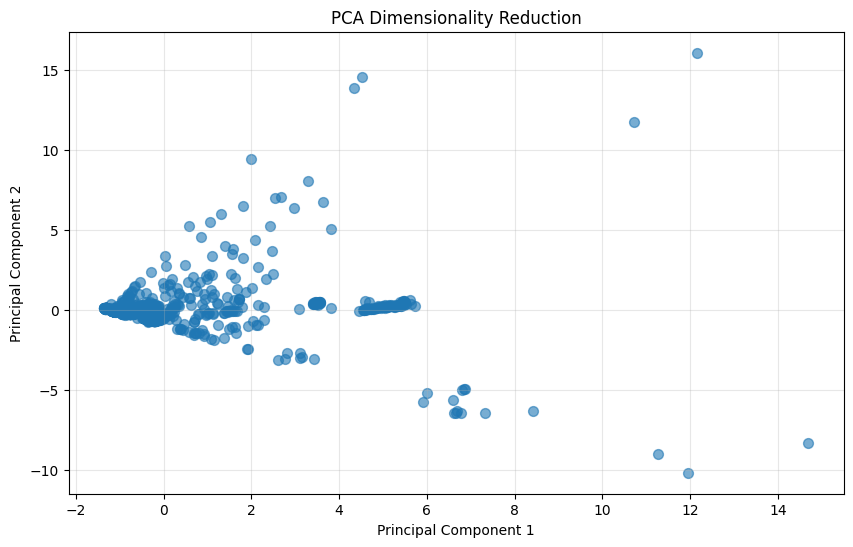

In [4]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {variance[0]*100:.2f}%")
print(f"Variance explained by PC2: {variance[1]*100:.2f}%")
print(f"Total variance captured: {sum(variance)*100:.2f}%")

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Dimensionality Reduction')
plt.grid(True, alpha=0.3)
plt.show()

K-means Cluster 0: 1110 hosts
K-means Cluster 1: 156 hosts


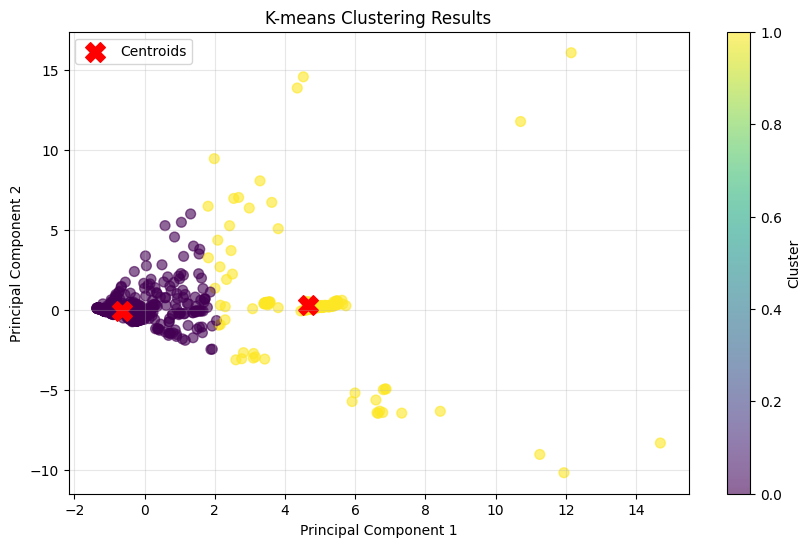

In [5]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_df)

unique_km, counts_km = np.unique(kmeans_labels, return_counts=True)
print(f"K-means Cluster 0: {counts_km[0]} hosts")
print(f"K-means Cluster 1: {counts_km[1]} hosts")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=kmeans_labels,
                      cmap='viridis', alpha=0.6, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Hierarchical Cluster 0: 141 hosts
Hierarchical Cluster 1: 1125 hosts


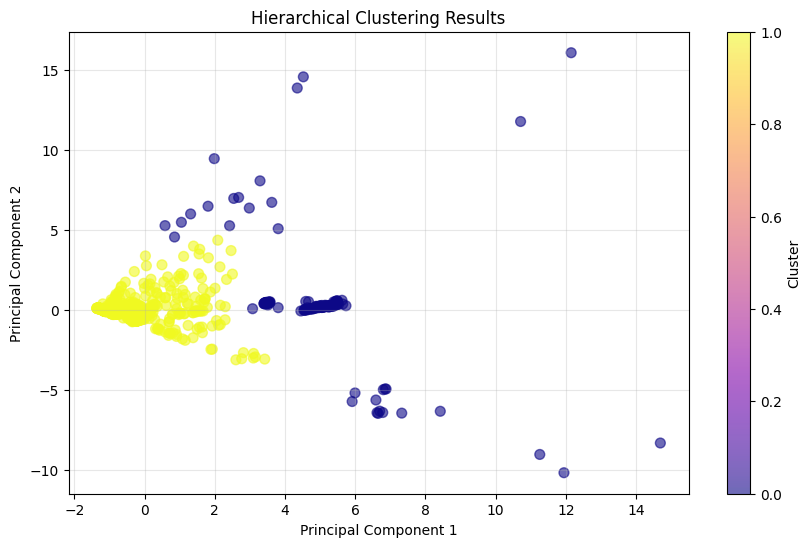

In [6]:
hierarchical = AgglomerativeClustering(n_clusters=2, linkage='ward')
hier_labels = hierarchical.fit_predict(pca_df)

unique_hc, counts_hc = np.unique(hier_labels, return_counts=True)
print(f"Hierarchical Cluster 0: {counts_hc[0]} hosts")
print(f"Hierarchical Cluster 1: {counts_hc[1]} hosts")

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=hier_labels,
                      cmap='plasma', alpha=0.6, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Hierarchical Clustering Results')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

Overloaded hosts: 137
Underloaded hosts: 1106
Balanced hosts: 23


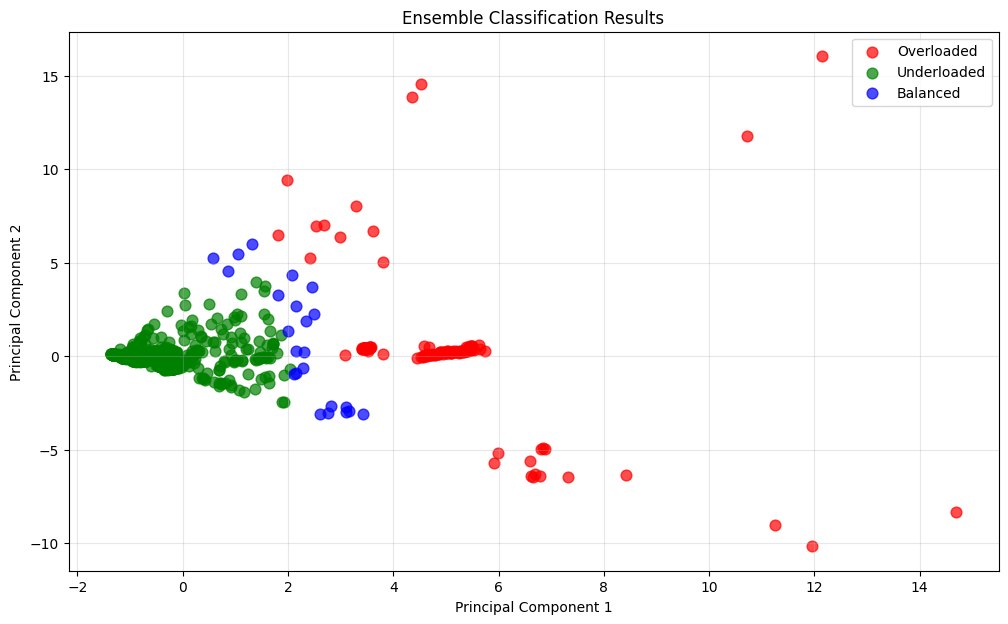

In [7]:
kmeans_high_cluster = 1 if pca_df[kmeans_labels == 1]['PC1'].mean() > pca_df[kmeans_labels == 0]['PC1'].mean() else 0
hier_high_cluster = 1 if pca_df[hier_labels == 1]['PC1'].mean() > pca_df[hier_labels == 0]['PC1'].mean() else 0

final_labels = []
for i in range(len(kmeans_labels)):
    km_vote = 'High' if kmeans_labels[i] == kmeans_high_cluster else 'Low'
    hc_vote = 'High' if hier_labels[i] == hier_high_cluster else 'Low'

    if km_vote == 'High' and hc_vote == 'High':
        final_labels.append('Overloaded')
    elif km_vote == 'Low' and hc_vote == 'Low':
        final_labels.append('Underloaded')
    else:
        final_labels.append('Balanced')

pca_df['Classification'] = final_labels

print(f"Overloaded hosts: {final_labels.count('Overloaded')}")
print(f"Underloaded hosts: {final_labels.count('Underloaded')}")
print(f"Balanced hosts: {final_labels.count('Balanced')}")

colors = {'Overloaded': 'red', 'Underloaded': 'green', 'Balanced': 'blue'}
plt.figure(figsize=(12, 7))

for classification in ['Overloaded', 'Underloaded', 'Balanced']:
    mask = pca_df['Classification'] == classification
    plt.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'],
                c=colors[classification], label=classification, alpha=0.7, s=60)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Ensemble Classification Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
pca_df['Load'] = pca_df['PC1']

overloaded_heap = []
underloaded_heap = []
balanced_heap = []

for idx, row in pca_df.iterrows():
    load = row['Load']
    classification = row['Classification']
    host_id = f"Host_{idx}"

    if classification == 'Overloaded':
        heapq.heappush(overloaded_heap, (-load, host_id, idx))
    elif classification == 'Underloaded':
        heapq.heappush(underloaded_heap, (load, host_id, idx))
    else:
        heapq.heappush(balanced_heap, (load, host_id, idx))

print(f"Overloaded heap size: {len(overloaded_heap)}")
print(f"Underloaded heap size: {len(underloaded_heap)}")
print(f"Balanced heap size: {len(balanced_heap)}")

if overloaded_heap:
    neg_load, host_id, idx = overloaded_heap[0]
    print(f"\nMost overloaded host: {host_id} with load {-neg_load:.3f}")

if underloaded_heap:
    load, host_id, idx = underloaded_heap[0]
    print(f"Least loaded host: {host_id} with load {load:.3f}")

Overloaded heap size: 137
Underloaded heap size: 1106
Balanced heap size: 23

Most overloaded host: Host_74 with load 14.694
Least loaded host: Host_252 with load -1.364


In [9]:
if overloaded_heap and underloaded_heap:
    neg_load_src, host_id_src, idx_src = heapq.heappop(overloaded_heap)
    source_load = -neg_load_src

    load_dst, host_id_dst, idx_dst = heapq.heappop(underloaded_heap)

    print("Container Migration Simulation")
    print(f"Source: {host_id_src}, Load: {source_load:.3f}")
    print(f"Destination: {host_id_dst}, Load: {load_dst:.3f}")

    migrated_load = source_load * 0.4
    new_source_load = source_load - migrated_load
    new_dest_load = load_dst + migrated_load

    print(f"\nAfter migration:")
    print(f"Source load: {new_source_load:.3f}")
    print(f"Destination load: {new_dest_load:.3f}")

    heapq.heappush(overloaded_heap, (-new_source_load, host_id_src, idx_src))
    heapq.heappush(underloaded_heap, (new_dest_load, host_id_dst, idx_dst))

Container Migration Simulation
Source: Host_74, Load: 14.694
Destination: Host_252, Load: -1.364

After migration:
Source load: 8.816
Destination load: 4.514


In [10]:
print("Implementation Summary")
print("="*50)
print(f"Total VMs analyzed: {len(dataset)}")
print(f"Original features: {dataset.shape[1]}")
print(f"\nPCA dimensionality reduction: {scaled_data.shape[1]} -> 2")
print(f"Total variance explained: {sum(variance)*100:.2f}%")
print(f"\nFinal classification:")
print(f"  Overloaded: {final_labels.count('Overloaded')}")
print(f"  Underloaded: {final_labels.count('Underloaded')}")
print(f"  Balanced: {final_labels.count('Balanced')}")
print(f"\nHeap structures:")
print(f"  Overloaded (max heap): {len(overloaded_heap)}")
print(f"  Underloaded (min heap): {len(underloaded_heap)}")
print(f"  Balanced (min heap): {len(balanced_heap)}")
print("="*50)

Implementation Summary
Total VMs analyzed: 1266
Original features: 11

PCA dimensionality reduction: 11 -> 2
Total variance explained: 52.73%

Final classification:
  Overloaded: 137
  Underloaded: 1106
  Balanced: 23

Heap structures:
  Overloaded (max heap): 137
  Underloaded (min heap): 1106
  Balanced (min heap): 23
